**Objetivo**: Carregar e testar a rede neural treinada


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
PATH = '/content/gdrive/Shareddrives/IA901 - Projeto Final/'
data_dir = PATH+'Datasets/Processed'

Mounted at /content/gdrive


In [2]:
# Criando pasta para salvar resultados preliminares/finais

PATHFinal = PATH+'Notebooks/FinalResults/'

if not os.path.exists(PATHFinal):
  os.mkdir(PATHFinal)

# Teste da rede neural treinada

In [3]:
# ______________________________________________________________________________
# Pegando resultados do experimento escolhido

print('Lista de experimentos disponíveis: ', os.listdir(PATH+"Notebooks/InterimResults/CellCounting/"))
print('Diga o numero do experimento que você gostaria de carregar (Experiment_Name)')
ExperimentName = str (input()) # por ex. 'DL_Baseline'

path_interim = PATH+"Notebooks/InterimResults/CellCounting/{}".format(ExperimentName)

print('Lista de subexperimentos disponíveis: ', os.listdir(path_interim)[1:])
print('Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)')
Experiment_Number = str (input())
subpath = path_interim+'/{}'.format(Experiment_Number)

Lista de experimentos disponíveis:  ['Experiment_I']
Diga o numero do experimento que você gostaria de carregar (Experiment_Name)
Experiment_I
Lista de subexperimentos disponíveis:  ['1']
Diga o numero do subexperimento que você gostaria de carregar (Experiment_Number)
1


In [4]:
PATHFinalExperiment = PATHFinal+'CellCounting/'

if not os.path.exists(PATHFinalExperiment):
  os.mkdir(PATHFinalExperiment)

# Configurações gerais e funções úteis para as análises

In [5]:
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import re
from sklearn import metrics
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image
from matplotlib.colors import LogNorm # escala log no eixo z

plt.ion()   # interactive mode

In [133]:
def Test_model(model):
    model.eval()

    Prediction = []
    Targets = []
    ImageID = []

    for inputs, labels, ID in dataloaders['test']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      #print('outputs: ', outputs)
      Prediction.extend(outputs.cpu().detach().numpy())
      Targets.extend(labels.cpu().detach().numpy())
      ImageID.extend(ID)


    return Prediction, Targets, ImageID

## Testando o modelo

## Carregar dados


In [126]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 'Image_'+str(self.data['Unnamed: 0'].iloc[idx])+'.png')
        image = Image.open(img_name).convert('RGB')  # Load the image

        ImageID = self.data['Unnamed: 0'].iloc[idx]

        target1 = self.data[['CancerCells']].iloc[idx].values[0]  # Get the first target value
        target2 = self.data[['TotalCells']].iloc[idx].values[0]  # Get the second target value

        target = np.array([target1, target2])
        #print('target: ', target)

        if self.transform is not None:
            image = self.transform(image)

        return image, torch.from_numpy(target), ImageID


In [178]:
size, padding = 224, 60 # tamanho de entrada da EfficientNet B1
data_transforms = {
    'test': transforms.Compose([
        transforms.Resize((size,size)),
        transforms.ToTensor()
    ])
}

In [179]:
TestDF = pd.read_csv(PATH+"Datasets/Processed/CellCounting/TestLabels.csv")
test_dir = PATH+'Datasets/Processed/CellCounting/test/'

image_datasets = {'test': CustomDataset(TestDF, test_dir, data_transforms['test'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=False, num_workers=2) for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(dataset_sizes)

{'test': 1571}


In [135]:
# Código que carrega melhor rede neural

# Define your model
model = models.efficientnet_b0(weights=True)
model.classifier[1] = nn.Linear(in_features= model.classifier[1].in_features, out_features=2)
model = model.to(device)

# Load your saved model
ModelPATH = subpath+'/Trained_DLModel.pt'
model.load_state_dict(torch.load(ModelPATH, map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [136]:
# Predicoes:
Prediction, Targets, ImageID = Test_model(model)

In [141]:
Pred = np.vstack(Prediction).round(decimals=0)
Tar = np.vstack(Targets)
ImID = np.vstack(ImageID).ravel()

Totaldf = pd.DataFrame({'ImID':ImID, 'CancerCells':Tar[:,0], 'TotalCells':Tar[:,1], 'Pred_CancerCells':Pred[:,0], 'Pred_TotalCells':Pred[:,1]})

In [142]:
Df1 = TestDF.sort_values(by=['Unnamed: 0'])
Df1 = Df1.drop(['TotalCells'], axis=1)
Df1 = Df1.drop(['CancerCells'], axis=1)
Df1

,Unnamed: 0,Types,Class
513,1,Breast,1.0
340,4,Breast,1.0
205,11,Breast,1.0
413,16,Breast,1.0
375,19,Breast,1.0
...,...,...,...
855,7865,Colon,0.0
747,7876,Colon,0.0
956,7879,Colon,1.0
795,7887,Colon,0.0


In [143]:
Df2 = Totaldf.sort_values(by=['ImID'])
Df2

,ImID,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells
513,1,8,10,7.0,13.0
340,4,3,7,6.0,9.0
205,11,9,14,7.0,11.0
413,16,7,12,8.0,11.0
375,19,2,13,1.0,6.0
...,...,...,...,...,...
855,7865,0,2,2.0,2.0
747,7876,0,18,-1.0,4.0
956,7879,28,46,18.0,47.0
795,7887,0,1,0.0,3.0


In [144]:
FinalDf = pd.concat([Df1,Df2],axis=1)
FinalDf = FinalDf.drop(['Unnamed: 0'], axis=1)
FinalDf['Pred_CancerCells'][FinalDf['Pred_CancerCells']<0] = 0
FinalDf['Pred_TotalCells'][FinalDf['Pred_TotalCells']<0] = 0
FinalDf

<ipython-input-144-b9a6d99c9023>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinalDf['Pred_CancerCells'][FinalDf['Pred_CancerCells']<0] = 0
<ipython-input-144-b9a6d99c9023>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FinalDf['Pred_TotalCells'][FinalDf['Pred_TotalCells']<0] = 0


,Types,Class,ImID,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells
513,Breast,1.0,1,8,10,7.0,13.0
340,Breast,1.0,4,3,7,6.0,9.0
205,Breast,1.0,11,9,14,7.0,11.0
413,Breast,1.0,16,7,12,8.0,11.0
375,Breast,1.0,19,2,13,1.0,6.0
...,...,...,...,...,...,...,...
855,Colon,0.0,7865,0,2,2.0,2.0
747,Colon,0.0,7876,0,18,0.0,4.0
956,Colon,1.0,7879,28,46,18.0,47.0
795,Colon,0.0,7887,0,1,0.0,3.0


In [145]:
FinalDf.describe()

,Class,ImID,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells
count,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000
mean,0.502864,4127.203692,9.206875,23.709102,9.356461,23.167410
std,0.500151,2281.305655,13.974995,20.490919,12.912306,20.239285
min,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000
25%,0.000000,2185.500000,0.000000,12.000000,0.000000,11.000000
50%,1.000000,4153.000000,1.000000,19.000000,3.000000,19.000000
75%,1.000000,6112.000000,15.000000,29.000000,15.000000,30.000000
max,1.000000,7898.000000,112.000000,196.000000,100.000000,225.000000


In [146]:
# Salvando predicoes finais
FinalDf.to_csv(PATHFinalExperiment+"FinalPrediction.csv", index=False, encoding='utf-8')

# Analises adicionais

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Carregando DF
FinalDf = pd.read_csv(PATHFinalExperiment+"FinalPrediction.csv")
FinalDf.iloc[:, (FinalDf.columns!='ImID')&(FinalDf.columns!='Class')].describe().round(2)

,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells
count,1571.00,1571.00,1571.00,1571.00
mean,9.21,23.71,9.36,23.17
std,13.97,20.49,12.91,20.24
min,0.00,0.00,0.00,0.00
25%,0.00,12.00,0.00,11.00
50%,1.00,19.00,3.00,19.00
75%,15.00,29.00,15.00,30.00
max,112.00,196.00,100.00,225.00


## General metrics

In [26]:
# Calculate evaluation metrics

Targets = FinalDf[['CancerCells', 'TotalCells']].values
Prediction = FinalDf[['Pred_CancerCells', 'Pred_TotalCells']].values

mse = mean_squared_error(Targets, Prediction)
mae = mean_absolute_error(Targets, Prediction)
r2 = r2_score(Targets, Prediction)

# Print the evaluation metrics (entire dataset)
print("Mean Squared Error (MSE):", round(mse,2))
print("Mean Absolute Error (MAE):", round(mae,2))

Mean Squared Error (MSE): 16.61
Mean Absolute Error (MAE): 2.49


Cancer cells as target: 
Mean Squared Error (MSE): 16.78
Mean Absolute Error (MAE): 2.24


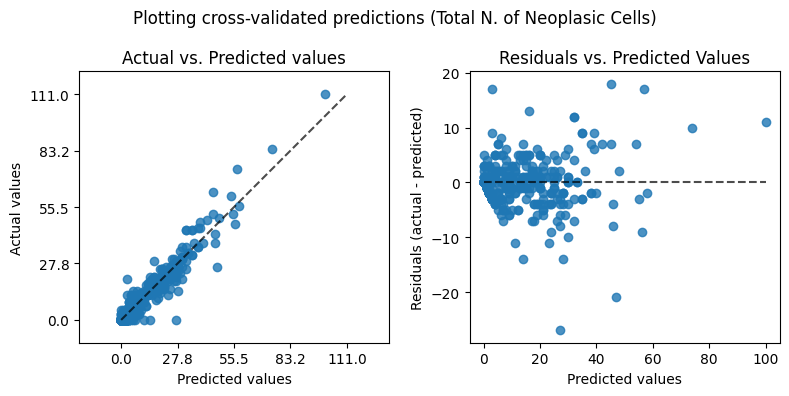

Total cells as target: 
Mean Squared Error (MSE): 16.45
Mean Absolute Error (MAE): 2.74


<Figure size 640x480 with 0 Axes>

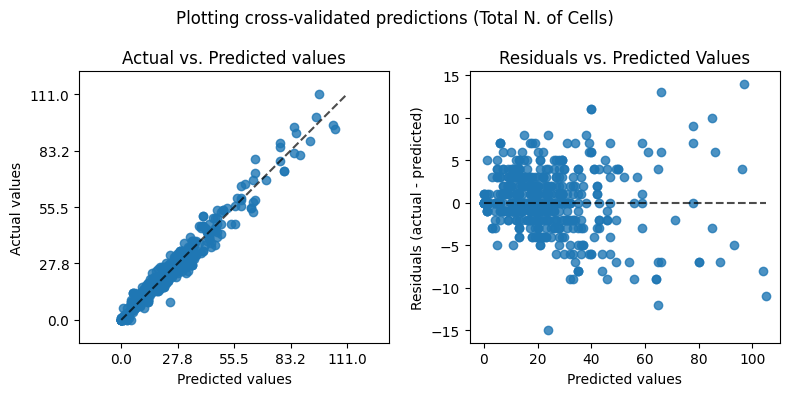

<Figure size 640x480 with 0 Axes>

In [54]:
# Per-target evaluation
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from sklearn.metrics import PredictionErrorDisplay

## Cancer cells:

Targets = FinalDf[['CancerCells']].values
Prediction = FinalDf[['Pred_CancerCells']].values

mse = mean_squared_error(Targets, Prediction)
mae = mean_absolute_error(Targets, Prediction)

# Print the evaluation metrics (entire dataset)
print('Cancer cells as target: ')
print("Mean Squared Error (MSE):", round(mse,2))
print("Mean Absolute Error (MAE):", round(mae,2))

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    Targets,
    y_pred=Prediction,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=42,
    subsample=500
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    Targets,
    y_pred=Prediction,
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=42,
    subsample=500
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions (Total N. of Neoplasic Cells)")
plt.tight_layout()
plt.savefig(PATHFinalExperiment+"/ScatterTotalNeoplasic.png")
plt.show()
plt.clf()

## Total cells:

Targets = FinalDf[['TotalCells']].values
Prediction = FinalDf[['Pred_TotalCells']].values

mse = mean_squared_error(Targets, Prediction)
mae = mean_absolute_error(Targets, Prediction)

# Print the evaluation metrics (entire dataset)
print('Total cells as target: ')
print("Mean Squared Error (MSE):", round(mse,2))
print("Mean Absolute Error (MAE):", round(mae,2))

fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    Targets,
    y_pred=Prediction,
    kind="actual_vs_predicted",
    ax=axs[0],
    random_state=42,
    subsample=500
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    Targets,
    y_pred=Prediction,
    kind="residual_vs_predicted",
    ax=axs[1],
    random_state=42,
    subsample=500
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions (Total N. of Cells)")
plt.tight_layout()
plt.savefig(PATHFinalExperiment+"/ScatterTotalCells.png")
plt.show()
plt.clf()

## Box Plot

In [28]:
FinalDf['TotalCells_AbsError'] = abs(FinalDf[['TotalCells']].values.ravel()-FinalDf[['Pred_TotalCells']].values.ravel())
FinalDf['CancerCells_AbsError'] = abs(FinalDf[['CancerCells']].values.ravel()-FinalDf[['Pred_CancerCells']].values.ravel())

In [29]:
FinalDf

,Types,Class,ImID,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells,TotalCells_AbsError,CancerCells_AbsError
0,Breast,1.0,1,8,10,7.0,13.0,3.0,1.0
1,Breast,1.0,4,3,7,6.0,9.0,2.0,3.0
2,Breast,1.0,11,9,14,7.0,11.0,3.0,2.0
3,Breast,1.0,16,7,12,8.0,11.0,1.0,1.0
4,Breast,1.0,19,2,13,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...
1566,Colon,0.0,7865,0,2,2.0,2.0,0.0,2.0
1567,Colon,0.0,7876,0,18,0.0,4.0,14.0,0.0
1568,Colon,1.0,7879,28,46,18.0,47.0,1.0,10.0
1569,Colon,0.0,7887,0,1,0.0,3.0,2.0,0.0


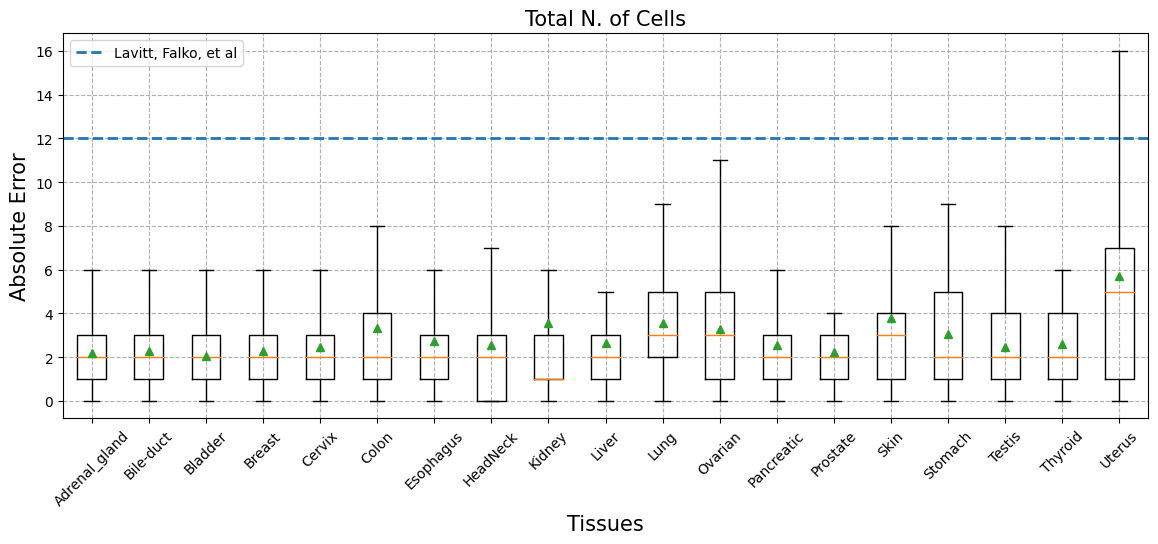

In [62]:
groups = FinalDf.groupby("Types")

fig, ax = plt.subplots(figsize=(14,5))

# Iterate over the tissue types
cont = 0
tissues = []
for tissue_type, group in groups:
    # Plotandp boxplot pra visualizar as diferencas estatisticas dos histogramas

    # Plotando boxplot
    ax.boxplot(group['TotalCells_AbsError'], positions=[cont], showfliers=False, showmeans=True, showcaps=True, widths=0.5)
    tissues.append(tissue_type)
    cont=cont+1

plt.plot([-0.5,18.5], [12,12], linewidth=2, linestyle='--', label='Lavitt, Falko, et al')
#plt.fill_between([-0.5,18.5], 12-15, 12+15, alpha=0.2)

ax.set_xticklabels(tissues, fontsize=10, rotation=45)
ax.set_xlabel('Tissues', fontsize=15)
ax.set_ylabel('Absolute Error', fontsize=15)
ax.set_title('Total N. of Cells', fontsize=15)
ax.grid(linestyle='--')
plt.legend()
plt.savefig(PATHFinalExperiment+"/BoxPlotTotalCells.png", bbox_inches='tight')

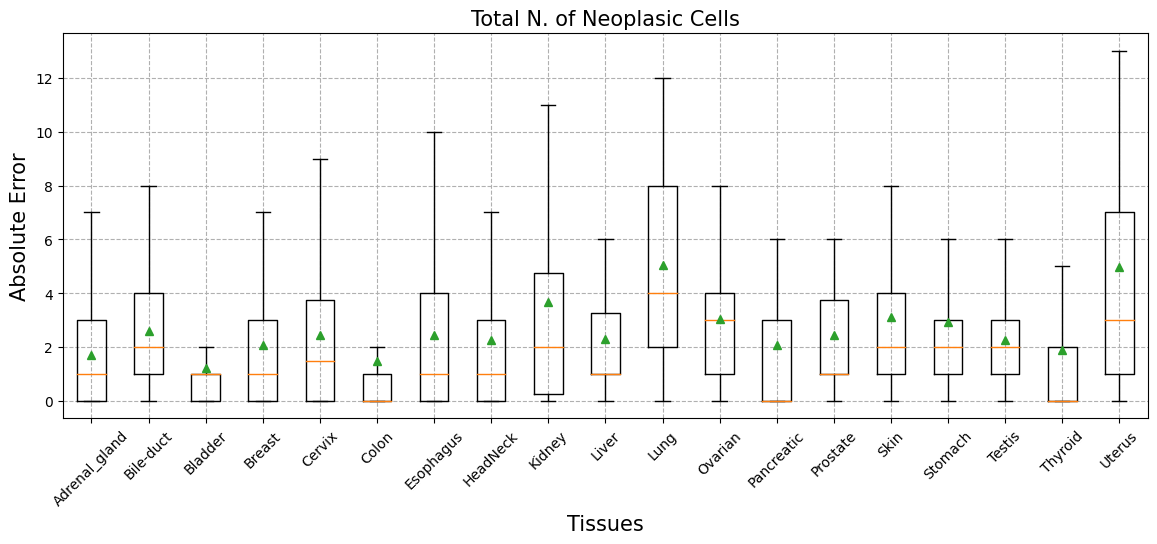

In [61]:
fig, ax = plt.subplots(figsize=(14,5))

# Iterate over the tissue types
cont = 0
tissues = []
for tissue_type, group in groups:
    # Plotandp boxplot pra visualizar as diferencas estatisticas dos histogramas

    # Plotando boxplot
    ax.boxplot(group['CancerCells_AbsError'], positions=[cont], showfliers=False, showmeans=True, showcaps=True, widths=0.5)
    tissues.append(tissue_type)
    cont=cont+1

ax.set_xticklabels(tissues, fontsize=10, rotation=45)
ax.set_xlabel('Tissues', fontsize=15)
ax.set_ylabel('Absolute Error', fontsize=15)
ax.set_title('Total N. of Neoplasic Cells', fontsize=15)
ax.grid(linestyle='--')
plt.savefig(PATHFinalExperiment+"/BoxPlotTotalNeoplasic.png", bbox_inches='tight')

# Análise das imagens

In [32]:
FinalDf

,Types,Class,ImID,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells,TotalCells_AbsError,CancerCells_AbsError
0,Breast,1.0,1,8,10,7.0,13.0,3.0,1.0
1,Breast,1.0,4,3,7,6.0,9.0,2.0,3.0
2,Breast,1.0,11,9,14,7.0,11.0,3.0,2.0
3,Breast,1.0,16,7,12,8.0,11.0,1.0,1.0
4,Breast,1.0,19,2,13,1.0,6.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...
1566,Colon,0.0,7865,0,2,2.0,2.0,0.0,2.0
1567,Colon,0.0,7876,0,18,0.0,4.0,14.0,0.0
1568,Colon,1.0,7879,28,46,18.0,47.0,1.0,10.0
1569,Colon,0.0,7887,0,1,0.0,3.0,2.0,0.0


In [47]:
CancerCellsToPlot = FinalDf.sort_values(by=['CancerCells_AbsError'])
TotalCellsToPlot = FinalDf.sort_values(by=['TotalCells_AbsError'])

In [51]:
TotalCellsToPlot

,Types,Class,ImID,CancerCells,TotalCells,Pred_CancerCells,Pred_TotalCells,TotalCells_AbsError,CancerCells_AbsError
1436,Kidney,0.0,7321,0,0,-0.0,0.0,0.0,0.0
1238,Bile-duct,1.0,6435,9,12,8.0,12.0,0.0,1.0
869,HeadNeck,0.0,4591,0,4,0.0,4.0,0.0,0.0
1027,Breast,0.0,5376,0,13,2.0,13.0,0.0,2.0
556,Breast,1.0,2991,23,23,21.0,23.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...
1491,Skin,1.0,7555,35,99,26.0,77.0,22.0,9.0
968,Colon,0.0,5089,0,90,0.0,68.0,22.0,0.0
183,Uterus,0.0,1062,0,196,0.0,225.0,29.0,0.0
257,Colon,0.0,1487,0,189,0.0,160.0,29.0,0.0


Types                   Colon
Class                     0.0
ImID                     7898
CancerCells                 0
TotalCells                 46
Pred_CancerCells          0.0
Pred_TotalCells          38.0
TotalCells_AbsError       8.0
CancerCells_AbsError      0.0
Name: 1570, dtype: object


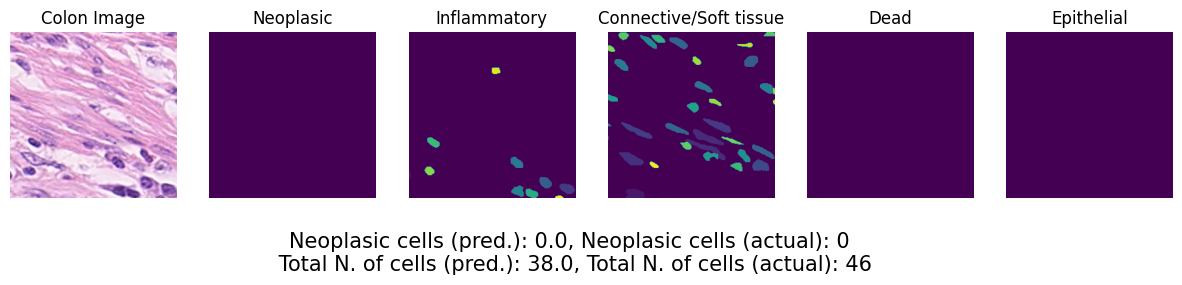

Types                   HeadNeck
Class                        0.0
ImID                        2141
CancerCells                    0
TotalCells                    16
Pred_CancerCells            -0.0
Pred_TotalCells             18.0
TotalCells_AbsError          2.0
CancerCells_AbsError         0.0
Name: 381, dtype: object


<Figure size 640x480 with 0 Axes>

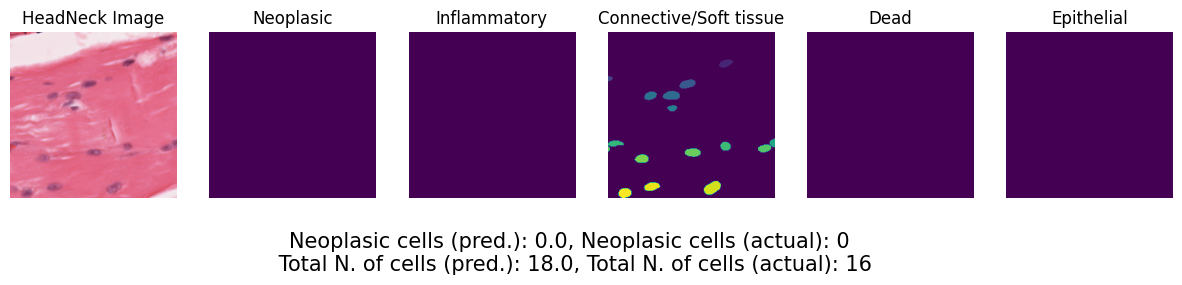

Types                   HeadNeck
Class                        0.0
ImID                        2146
CancerCells                    0
TotalCells                    11
Pred_CancerCells             0.0
Pred_TotalCells              6.0
TotalCells_AbsError          5.0
CancerCells_AbsError         0.0
Name: 382, dtype: object


<Figure size 640x480 with 0 Axes>

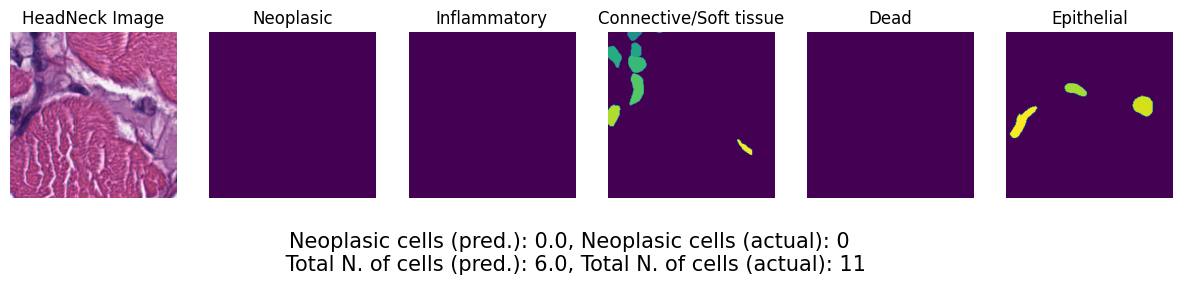

<Figure size 640x480 with 0 Axes>

In [66]:
# Carregar imagem e respectivas masks

NImages = 3
PlotCancerCells = True
PlotBestScores = True
for k in range(0,NImages):
  if PlotBestScores:
    index = k
  else:
    index = -k
  if PlotCancerCells:
    DFSelected = CancerCellsToPlot.iloc[k,:]
  else:
    DFSelected = TotalCellsToPlot.iloc[k,:]
  print(DFSelected)

  ImageIndex = DFSelected['ImID']

  # Carregando imagem e mask
  file_dir = "/content/gdrive/Shareddrives/IA901 - Projeto Final/Datasets/Interim/"
  image_path = os.path.join(file_dir, "Images/Image_"+str(ImageIndex) + '.png')
  masks_path = os.path.join(file_dir, "Masks/Mask_"+str(ImageIndex) + '.npy')

  # Load and plot the image
  image = plt.imread(image_path)
  img_masks = np.load(masks_path)

  Channels = ['{} Image'.format(DFSelected['Types']), 'Neoplasic', 'Inflammatory','Connective/Soft tissue', 'Dead', 'Epithelial']

  # Plot the incorrect images
  fig, axs = plt.subplots(1, 6, figsize=(15, 8))
  axs = axs.flatten()
  for i in range(6):

      if i==0:
        axs[i].imshow(image)
      else:
        axs[i].imshow(img_masks[:, :, i-1])
        #print('Unique: ', len(np.unique(img_masks[:, :, i-1].astype('uint8')))-1)
      axs[i].set_title('{}'.format(Channels[i]))
      axs[i].axis('off')

  fig.text(0.5, 0.3, 'Neoplasic cells (pred.): {}, Neoplasic cells (actual): {} \n Total N. of cells (pred.): {}, Total N. of cells (actual): {}'.format(
      abs(DFSelected['Pred_CancerCells']),DFSelected['CancerCells'],abs(DFSelected['Pred_TotalCells']),DFSelected['TotalCells']), ha='center',fontsize=15)
  plt.savefig(PATHFinalExperiment+"/CellCounts_Image_{}.png".format(ImageIndex), bbox_inches='tight')
  plt.show()
  plt.clf()